# Imports

In [59]:
import cvxpy
import matplotlib.pyplot as plt
import numpy
import numpy.random
from scipy.optimize import shgo, direct, lsq_linear, least_squares

# Useful mathematical functions

In [87]:
def powermean(xx,mean_power=2.0,**kwargs):
    #print(f"xx:{xx}, mean_power:{mean_power}")
    average = numpy.average(numpy.power(xx,mean_power))
    return numpy.sign(average)*numpy.power(numpy.abs(average),1.0/mean_power)

In [116]:
def penalize_negative_exp(xx,penalty_exponent=1.0,**kwargs):
    return numpy.exp(-xx*penalty_exponent)

# Sum of positive monomials

## Monomials

In [4]:
max_monomial_coef = 20

In [119]:
def monomial(xx, degree, coef):
    return coef*numpy.power(xx,degree)

# Returns the optimal coefficient (using a powermean of differences)
# max_degree is the maximum degree of differences to evaluate
# diff_margin is the margin to allow differences to go into the negative. Currently an absolute value.
def optimize_coef_monomial(xx, yy, degree, max_monomial_coef=max_monomial_coef, **kwargs):
    def ff_coef(coef):
        return monomial(xx,degree,coef)

    def deltas_coef(coef):
        return yy - ff_coef(coef)   
        
    def obj_func(coef):
        deltas = deltas_coef(coef)   
        penalty_negative = penalize_negative_exp(deltas,**kwargs)
        abs_deltas = numpy.abs(deltas)
        return float(powermean(abs_deltas+penalty_negative,**kwargs))
        #penalty_negative = numpy.where(deltas < 0, penalize_negative_exp(deltas,**kwargs), 1.0)
        #return float(powermean(deltas*penalty_negative,**kwargs))
    
    bounds = [(0,max_monomial_coef)]
    
    result = shgo(obj_func, bounds)

    if result.x is None or not result.success:
        return 0.0, obj_func(0.0)

    return result.x[0], result.fun

In [128]:
max_polynomial_degree = 64
max_polynomial_degree_exponent = 8

In [143]:
def candidate_degrees_all(max_polynomial_degree=max_polynomial_degree):
    return range(1,max_polynomial_degree+1)

def candidate_degrees_exponential(max_polynomial_degree_exponent=max_polynomial_degree_exponent):
    return [2**i for i in range(max_polynomial_degree_exponent)]

def candidate_degrees_handcrafted():
    return [1,2,3,4,5,7,11,13,17,19,23,29,31,37,41,43,47,53,59,61,67,71,73,79,83,89,97]

def discrete_optimize_scan(obj_fun,candidates):
    min_value = numpy.inf
    min_candidate = None
    for candidate in candidates:
        value = obj_fun(candidate)
        #print(f"candidate:{candidate}, value:{value}")
        if value < min_value:
            min_candidate = candidate
            min_value = value

    return min_candidate,min_value

In [144]:
def optimize_degree_monomial(xx, yy, candidate_degrees=candidate_degrees_handcrafted, **kwargs):    
    bounds = [(1,max_polynomial_degree)]
    mean_yy = numpy.average(yy)    

    def obj_func(degree):
        coef, diff = optimize_coef_monomial(xx, yy, degree, **kwargs)

        return diff
    
    degree,diff = discrete_optimize_scan(obj_func,candidate_degrees())        
    
    #bounds = [(1,2**max_polynomial_degree_exponent)]
    #result = shgo(obj_func, bounds)
    #if result.x is None or not result.success:
    #    return 0.0, 0.0, 0.0
    #degree = result.x[0]
    
    coef, diff = optimize_coef_monomial(xx, yy, degree, **kwargs)

    #print(f"degree: {degree}, coef: {coef}, diff: {diff}")
    return degree, coef, diff

In [145]:
initial_reserve = 0.4
reserve_factor = 0.95
min_coef = 0.0001
mean_power = 2

In [146]:
def decompose_monomial_sum(xx, yy, initial_reserve = initial_reserve, reserve_factor = reserve_factor, mean_power=mean_power, min_coef=min_coef, **kwargs):
    mean_yy = numpy.average(yy)
    
    result = {}
    cur_reserve = initial_reserve

    coef = 1
    while coef > min_coef:
        degree, coef, diff = optimize_degree_monomial(xx, yy, mean_power=mean_power)        
        #print(f"degree: {degree}, coef: {coef}, diff: {diff}")
        
        cur_factor = 1.0 - cur_reserve
        
        cur_coef = result.get(degree,0)
        cur_coef += cur_factor*coef

        result[degree] = cur_coef

        yy = yy - monomial(xx, degree, coef*cur_factor)
        cur_reserve *= reserve_factor               

    return result

In [95]:
def monomial_sum(xx,params,**kwargs):
    result = numpy.zeros_like(xx)
    for degree,coef in params.items():
        result += monomial(xx,degree,coef)

    return result

def monomial_sum_str(params,**kwargs):
    result = ""
    for degree,coef in params.items():
        result += f" + {coef}x^{degree}"

    return result

In [122]:
min_final_coef_prop=0.01
max_n_coefs=6

In [123]:
def filter_monomial_sum(sum_dict,min_final_coef_prop=min_final_coef_prop,max_n_coefs=max_n_coefs):
    max_coef = 0.0
    for degree,coef in sum_dict.items():
        if coef > max_coef:
            max_coef = coef

    if max_coef == 0.0:
        return sum_dict
        
    result = {}
    for degree,coef in sum_dict.items():
        if coef/max_coef > min_final_coef_prop:
            result[degree] = coef

    limited_result = dict(sorted(result.items(), key=lambda e: e[1], reverse=True)[:max_n_coefs])
    
    return limited_result

# Evaluation

In [139]:
def generate_sample(f,number_samples=200,exponential_noise_mean_mult=0.0,**kwargs):       
    xx = numpy.sort(numpy.random.random_sample(number_samples))
    yy = f(xx)

    # Add noise
    if exponential_noise_mean_mult > 0:
        noise = numpy.random.exponential(scale=exponential_noise_mean_mult,size=number_samples)        
    else:
        noise = 0

    return (xx,yy*(1.0+noise))

def loss_penalize_negative(deltas, **kwargs):
    penalty_negative = numpy.where(deltas < 0, penalize_negative_exp(deltas,**kwargs), 1.0)
    return deltas*penalty_negative
    
number_samples_test=200
# Returns a dictionary with entries:
#  - xx
#  - yy
#  - params
#  - fit_nmse
#  - fit_loss
#  - source_nmse
#  - source_loss
def evaluate_monomial_sum_fit(f,number_samples,number_samples_test=number_samples_test,**kwargs):
    (xx,yy) = generate_sample(f,number_samples=number_samples,**kwargs)

    params = filter_monomial_sum(decompose_monomial_sum(xx, yy, **kwargs))

    fit_residuals = yy - monomial_sum(xx,params)

    fit_mse = numpy.average(fit_residuals * fit_residuals)
    fit_nmse = fit_mse/f(1)
    fit_loss = powermean(loss_penalize_negative(fit_residuals,**kwargs),**kwargs)

    xx2 = numpy.linspace(0,1,number_samples_test)
    yy2 = f(xx2)
    source_residuals = yy2 - monomial_sum(xx2,params)
    source_loss = powermean(loss_penalize_negative(source_residuals,**kwargs),**kwargs)

    source_mse = numpy.average(source_residuals * source_residuals)
    source_nmse = source_mse/f(1)

    return {"xx": xx, "yy": yy, "params":params, "fit_nmse":fit_nmse, "fit_loss":fit_loss, "source_nmse":source_nmse, "source_loss":source_loss}

In [15]:
def plot_monomial_sum_fit(f, f_desc, params, xx, yy, **kwargs):    
    oo = numpy.linspace(0,1,200)
    
    original_ff = f(oo)

    fitted_ff = monomial_sum(oo,params)
    
    plt.plot(oo,original_ff,c="c",linestyle="dotted",alpha=1,label=f_desc)
    plt.plot(oo,fitted_ff,c="r",linestyle="dashed",alpha=1,label=monomial_sum_str(params,**kwargs))
    plt.scatter(xx,yy,c="k",alpha=0.1,marker="x",label="Fit to sampled points")   

In [82]:
# Using cvxpy
def cvxpy_fit(f, xx, yy, number_samples_test=number_samples_test,**kwargs):
    l = len(xx)
    ff_var = cvxpy.Variable(l)

    objective = cvxpy.Minimize(cvxpy.sum_squares(ff_var - yy))

    constraints = [
        ( (ff_var[i+2] - ff_var[i+1]) / (xx[i+2] - xx[i+1]) -
          (ff_var[i+1] - ff_var[i]) / (xx[i+1] - xx[i]) ) >= 0
        for i in range(l - 2)
    ]

    problem = cvxpy.Problem(objective, constraints)
    problem.solve()

    ff = ff_var.value

    fit_residuals = ff-yy

    fit_mse = numpy.average(fit_residuals * fit_residuals)
    fit_nmse = fit_mse/f(1)
    fit_loss = powermean(loss_penalize_negative(fit_residuals,**kwargs),**kwargs)

    xx2 = numpy.linspace(0,1,number_samples_test)
    yy2 = f(xx2)
    ff2 = numpy.interp(xx2,xx,ff)
    source_residuals = ff2-yy2
    source_loss = powermean(loss_penalize_negative(source_residuals,**kwargs),**kwargs)

    source_mse = numpy.average(source_residuals * source_residuals)
    source_nmse = source_mse/f(1)

    return {"xx": xx, "yy":yy, "ff":ff, "fit_nmse":fit_nmse, "fit_loss":fit_loss, "source_nmse":source_nmse, "source_loss":source_loss}

def plot_cvxpy_fit(f, f_desc, xx, ff, **kwargs):    
    plt.plot(xx,ff,c="y",linestyle="dashdot",alpha=1,label="Convex fit")

In [120]:
vander_degree = 64
def vander_fit(f, xx, yy, number_samples_test=number_samples_test,**kwargs):
    vander_matrix = numpy.vander(xx, N=vander_degree + 1, increasing=True)

    def vander_obj(coefs, vander_matrix, yy, **kwargs):
        deltas = yy - vander_matrix @ coefs
        #penalty_negative = numpy.where(deltas < 0, penalize_negative_exp(deltas,**kwargs), 1.0)
        #return deltas*penalty_negative
        penalty_negative = penalize_negative_exp(deltas,**kwargs)
        abs_deltas = numpy.abs(deltas)
        return abs_deltas + penalty_negative
        
    #res = lsq_linear(vander_matrix, yy, bounds=(0, numpy.inf))
    res = least_squares(vander_obj, x0=numpy.ones(vander_degree+1), bounds=(0, numpy.inf), args=(vander_matrix, yy))
    
    coefs = res.x
    coefs = filter_monomial_sum({degree:coefs[degree] for degree in range(vander_degree)})
    
    ff = monomial_sum(xx,coefs)

    fit_residuals = ff-yy

    fit_mse = numpy.average(fit_residuals * fit_residuals)
    fit_nmse = fit_mse/f(1)
    fit_loss = powermean(loss_penalize_negative(fit_residuals,**kwargs),**kwargs)

    xx2 = numpy.linspace(0,1,number_samples_test)
    yy2 = f(xx2)
    ff2 = numpy.interp(xx2,xx,ff)
    source_residuals = ff2-yy2
    source_loss = powermean(loss_penalize_negative(source_residuals,**kwargs),**kwargs)

    source_mse = numpy.average(source_residuals * source_residuals)
    source_nmse = source_mse/f(1)

    return {"xx": xx, "yy":yy, "ff":ff, "fit_nmse":fit_nmse, "fit_loss":fit_loss, "source_nmse":source_nmse, "source_loss":source_loss, "coefs":coefs}

def plot_vander_fit(f, f_desc, coefs_vander, xx, ff, **kwargs):    
    #plt.plot(xx,ff,c="g",linestyle="dashdot",alpha=1,label=f"Linear least squares polynomial fit: {monomial_sum_str(coefs_vander)}")

    oo = numpy.linspace(0,1,200)
    
    fitted_ff = monomial_sum(oo,coefs_vander)
        
    plt.plot(oo,fitted_ff,c="g",linestyle="dashdot",alpha=1,label=f"Linear least squares polynomial fit: {monomial_sum_str(coefs_vander,**kwargs)}")

In [28]:
number_tests = 100
def monomial_sum_fit_many(f,number_samples,number_tests=number_tests,**kwargs):
    results = []
    #for i in tqdm(range(number_tests)):
    for i in range(number_tests):
        result = evaluate_monomial_sum_fit(f,number_samples,**kwargs)

        results.append(result)

        if i % 10 == 9:
            print(f"{i+1} tests completed")

    results_source_nmse = numpy.array([result["source_nmse"] for result in results])

    max_source_nmse = numpy.max(results_source_nmse)
    avg_source_nmse = numpy.average(results_source_nmse)
    avg_diffs = numpy.abs(results_source_nmse - avg_source_nmse)
    min_avg_diff = numpy.min(avg_diffs)

    max_result = [result for result in results if result["source_nmse"] == max_source_nmse][0]
    avg_result = [result for result in results if numpy.abs(result["source_nmse"]-avg_source_nmse) == min_avg_diff][0]

    return {"max_source_nmse":max_source_nmse, "avg_source_nmse":avg_source_nmse, "avg_result":avg_result, "worst_result":max_result}

In [135]:
def plot_full_result_monomial_sum_fit(fit_function, function_desc,
                                              number_samples, number_samples_test, exponential_noise_mean_mult,
                                              result,
                                              **kwargs):
    params = result["params"]
    xx = result["xx"]
    yy = result["yy"]
    fit_nmse = result["fit_nmse"]
    fit_loss = result["fit_loss"]
    source_nmse = result["source_nmse"]
    source_loss = result["source_loss"]
    
    result_cvxpy = cvxpy_fit(fit_function,
                             xx,
                             yy,
                             number_samples_test=number_samples_test,
                             **kwargs)
    
    ff_cvxpy = result_cvxpy["ff"]
    fit_nmse_cvxpy = result_cvxpy["fit_nmse"]
    fit_loss_cvxpy = result_cvxpy["fit_loss"]
    source_nmse_cvxpy = result_cvxpy["source_nmse"]
    source_loss_cvxpy = result_cvxpy["source_loss"]

    result_vander = vander_fit(fit_function,
                             xx,
                             yy,
                             number_samples_test=number_samples_test,
                             **kwargs)
    
    fit_nmse_vander = result_vander["fit_nmse"]
    fit_loss_vander = result_vander["fit_loss"]
    source_nmse_vander = result_vander["source_nmse"]
    source_loss_vander = result_vander["source_loss"]
    coefs_vander = result_vander["coefs"]
    ff_vander = monomial_sum(xx,coefs_vander)    
    
    if exponential_noise_mean_mult == 0:
        plot_title = f"Absolutely monotonic polynomial fit for {function_desc} (N={number_samples})\n" +\
                        f"Fit NMSE={fit_nmse:.2e},Loss={fit_loss:.2e}, Source NMSE={source_nmse:.2e},Loss={source_loss:.2e}\n" +\
                        f"cvxpy Fit NMSE={fit_nmse_cvxpy:.2e},Loss={fit_loss_cvxpy:.2e}, cvxpy Source NMSE={source_nmse_cvxpy:.2e},Loss={source_loss_cvxpy:.2e}\n" +\
                        f"polynomial lsq Fit NMSE={fit_nmse_vander:.2e},Loss={fit_loss_vander:.2e}, polynomial lsq Source NMSE={source_nmse_vander:.2e},Loss={source_loss_vander:.2e}\n"
    else:
        plot_title = f"Absolutely monotonic polynomial fit for {function_desc} (N={number_samples}, exponential noise mean={exponential_noise_mean_mult:.2f})\n" +\
                        f"Fit NMSE={fit_nmse:.2e},Loss={fit_loss:.2e}, Source NMSE={source_nmse:.2e},Loss={source_loss:.2e}\n" +\
                        f"cvxpy Fit NMSE={fit_nmse_cvxpy:.2e},Loss={fit_loss_cvxpy:.2e}, cvxpy Source NMSE={source_nmse_cvxpy:.2e},Loss={source_loss_cvxpy:.2e}\n" +\
                        f"polynomial lsq Fit NMSE={fit_nmse_vander:.2e},Loss={fit_loss_vander:.2e}, polynomial lsq Source NMSE={source_nmse_vander:.2e},Loss={source_loss_vander:.2e}\n"
        
    plot_monomial_sum_fit(fit_function,function_desc,params,xx,yy,**kwargs)
    plot_cvxpy_fit(fit_function,function_desc,xx,ff_cvxpy,**kwargs)
    plot_vander_fit(fit_function,function_desc,coefs_vander,xx,ff_vander,**kwargs)
    
    ax = plt.gca()
    ax.set_xlim([0,1])
    
    plt.title(plot_title)
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), fontsize="x-small")
        
    plt.show()

## Evaluated functions

In [52]:
f1_desc = "e^x - normalized"
f1_zero = 1
f1_factor = numpy.divide(1.0,numpy.exp(1)-f1_zero)
def f1(x):
    return f1_factor*(numpy.exp(x) - f1_zero)

f2_desc = "e^(e^x) - normalized"
f2_zero = numpy.exp(1)
f2_factor = numpy.divide(1.0,numpy.exp(numpy.exp(1))-f2_zero)
def f2(x):
    return f2_factor*(numpy.exp(numpy.exp(x)) - f2_zero)

f3_desc = "e^(e^(e^x)) - normalized"
f3_zero = numpy.exp(numpy.exp(1))
f3_factor = numpy.divide(1.0,numpy.exp(numpy.exp(numpy.exp(1)))-f3_zero)
def f3(x):
    return f3_factor*(numpy.exp(numpy.exp(numpy.exp(x))) - f3_zero)

f4_desc = "x^2"
def f4(x):
    return x*x

f5_desc = "x^5+2x^4+x^3+x"
def f5(x):
    return numpy.power(x,5) + 2*numpy.power(x,4) + numpy.power(x,3) + x

f6_desc = "3x^2-x^3"
def f6(x):
    return 3*numpy.power(x,2) - numpy.power(x,3)

f7_desc = "x^4-4x^3+6x^2"
def f7(x):
    return numpy.power(x,4)-4*numpy.power(x,3)+6*numpy.power(x,2)

f8_desc = "sin(pi/2 x - pi/2) + 1"
def f8(x):
    return numpy.sin(x*numpy.pi/2 - numpy.pi/2) + 1

f9_desc = "4x^2 {[0,0.5]} || 4x-1 {[0.5,1]}"
def f9(x):
    return numpy.where(x < 0.5, 4*numpy.power(x,2), 4*x-1)

functions = [(f1,f1_desc),(f2,f2_desc),(f3,f3_desc),(f4,f4_desc),(f5,f5_desc),(f6,f6_desc),(f7,f7_desc),(f8,f8_desc),(f9,f9_desc)]
#functions = [(f1,f1_desc)]

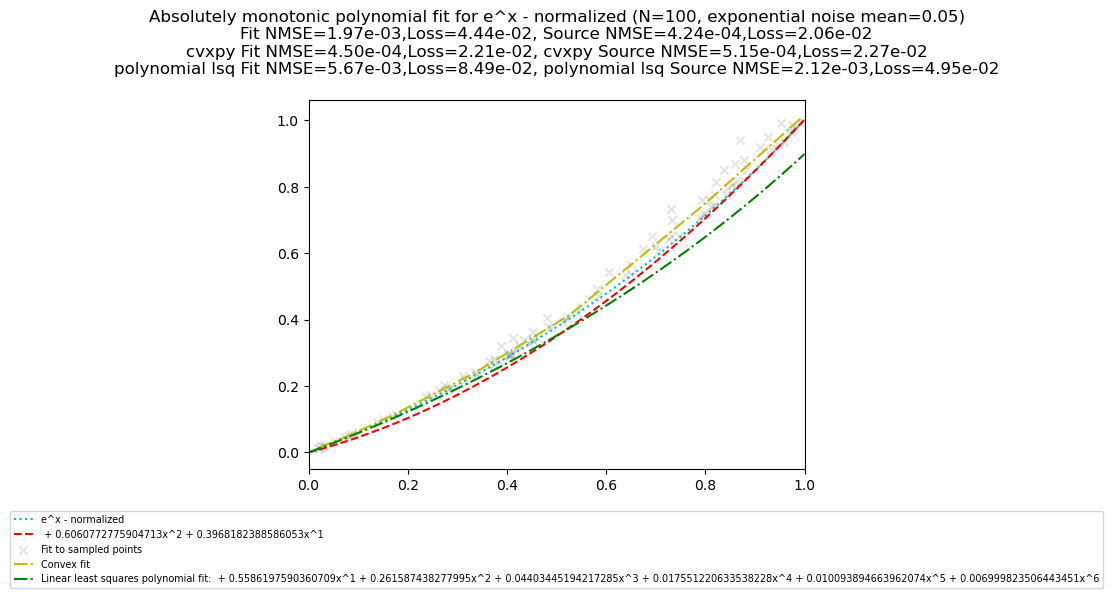

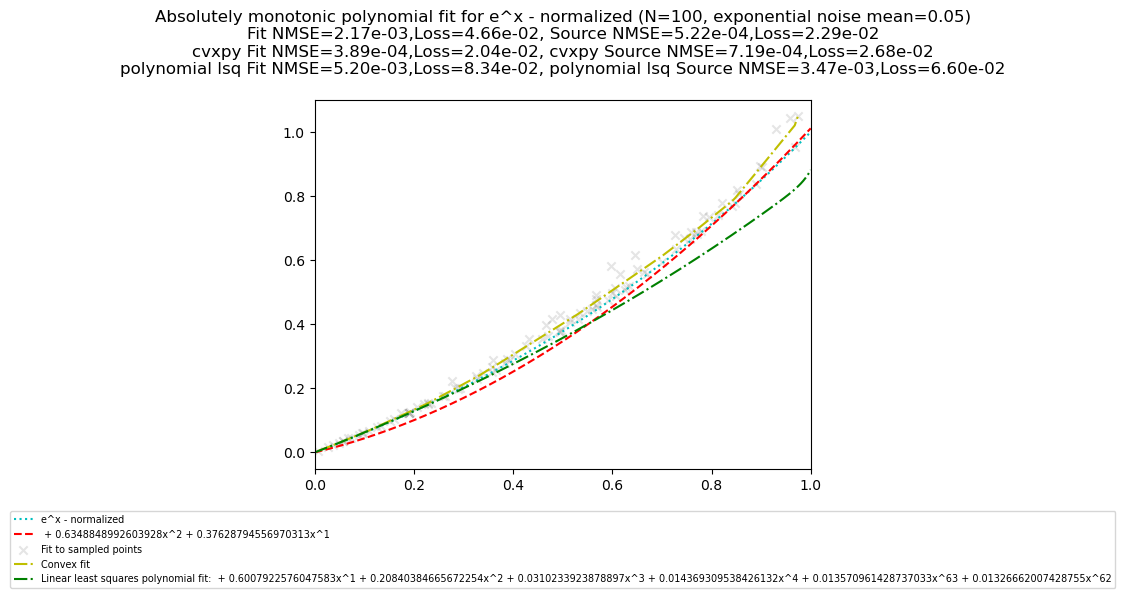

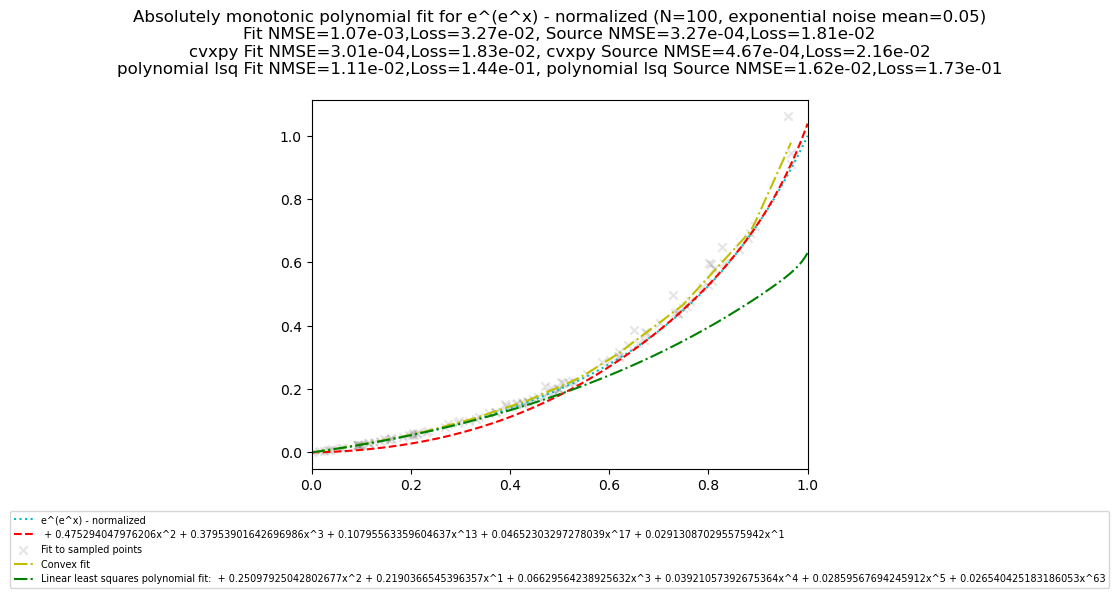

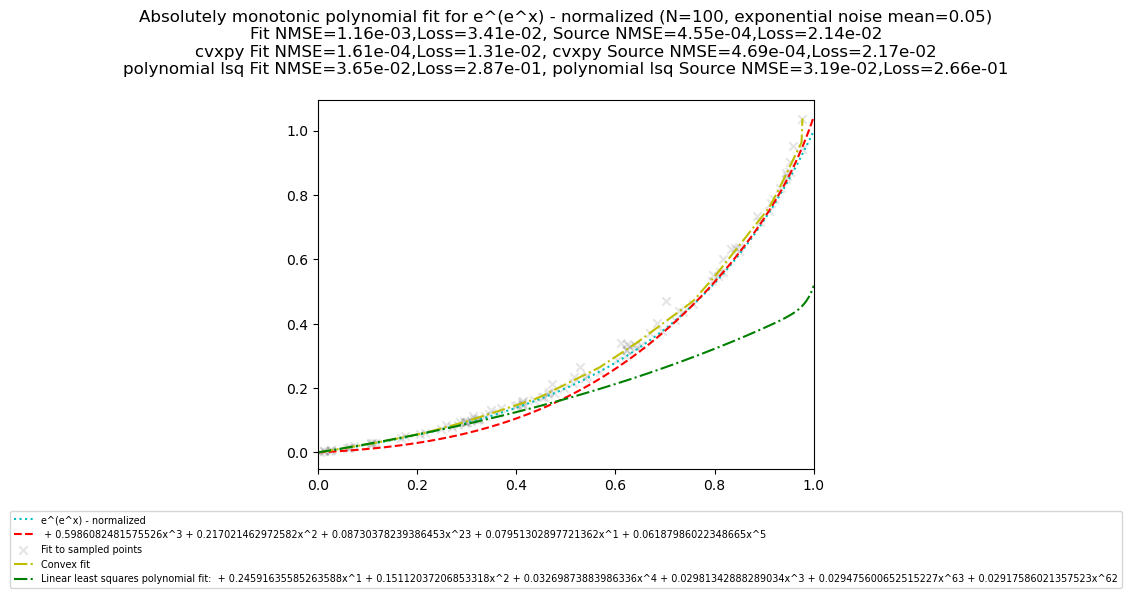

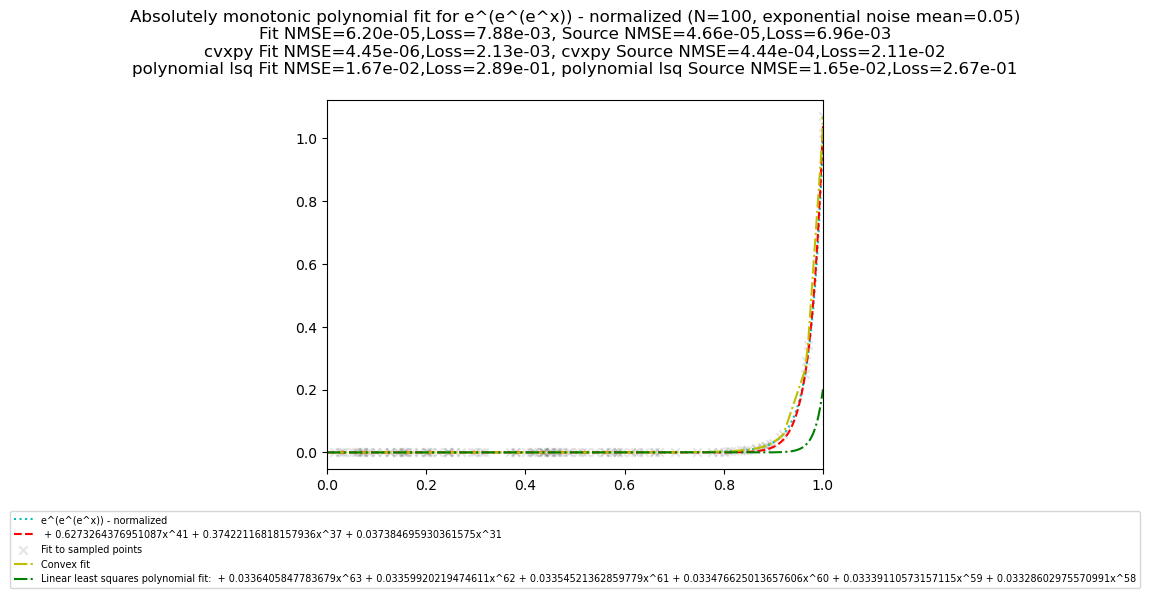

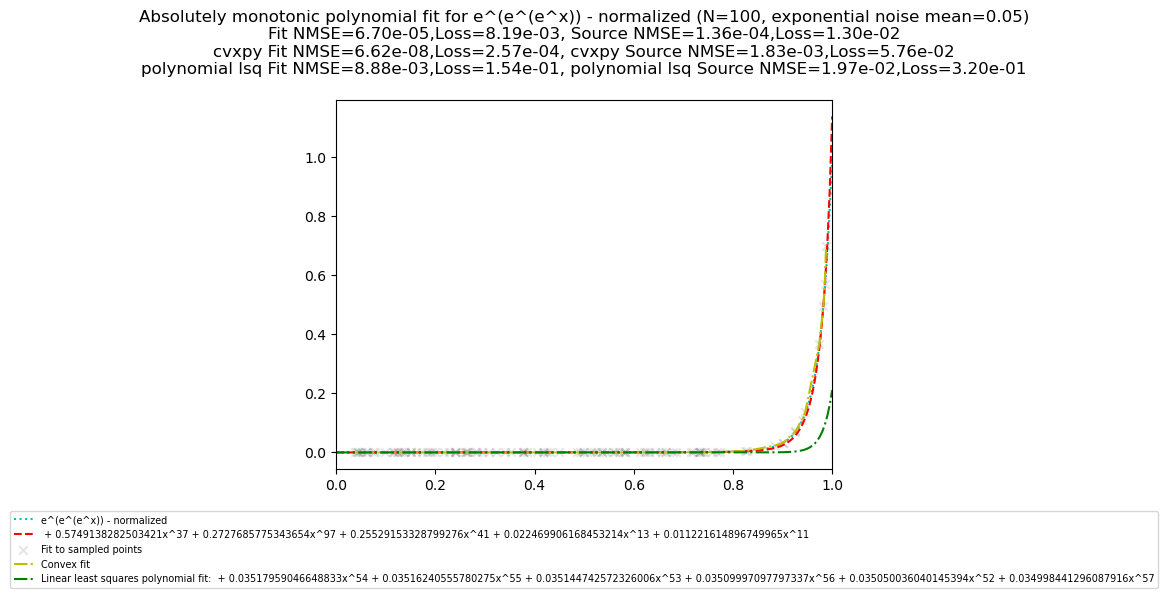

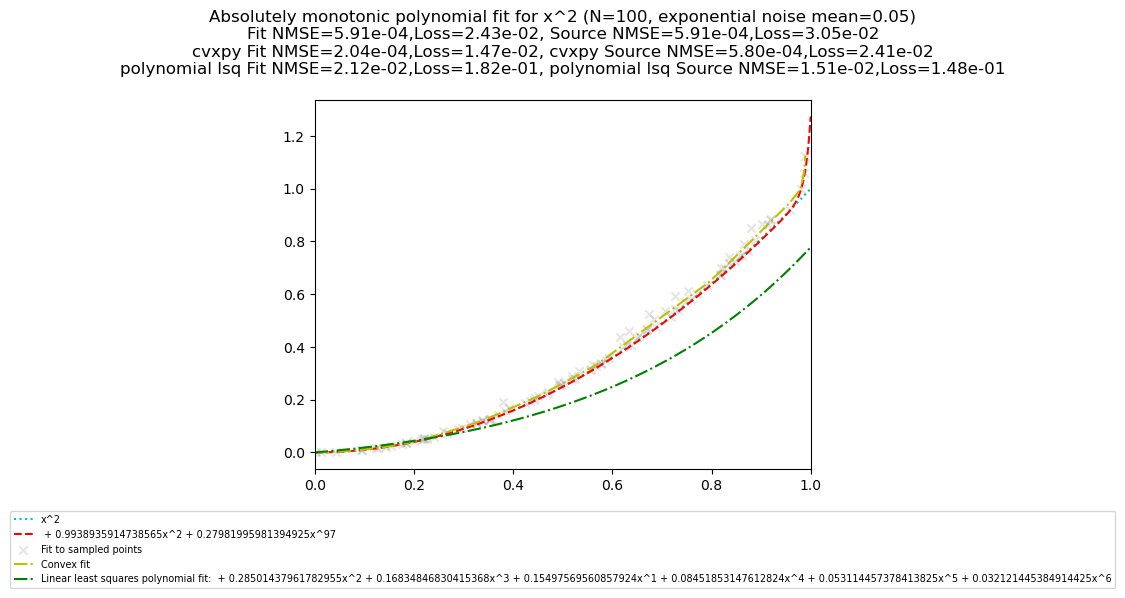

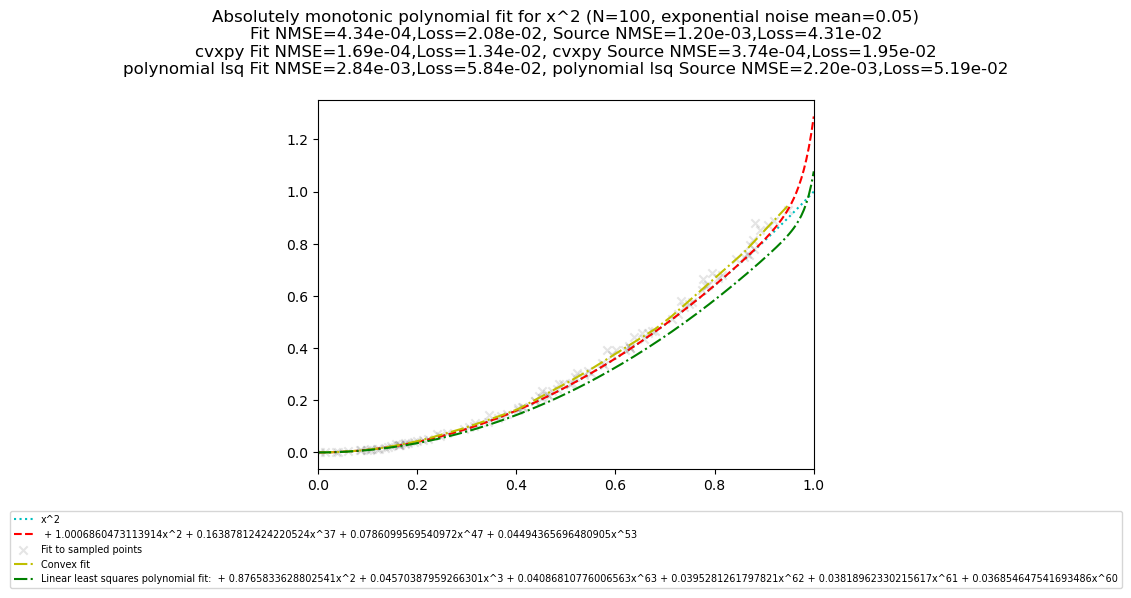

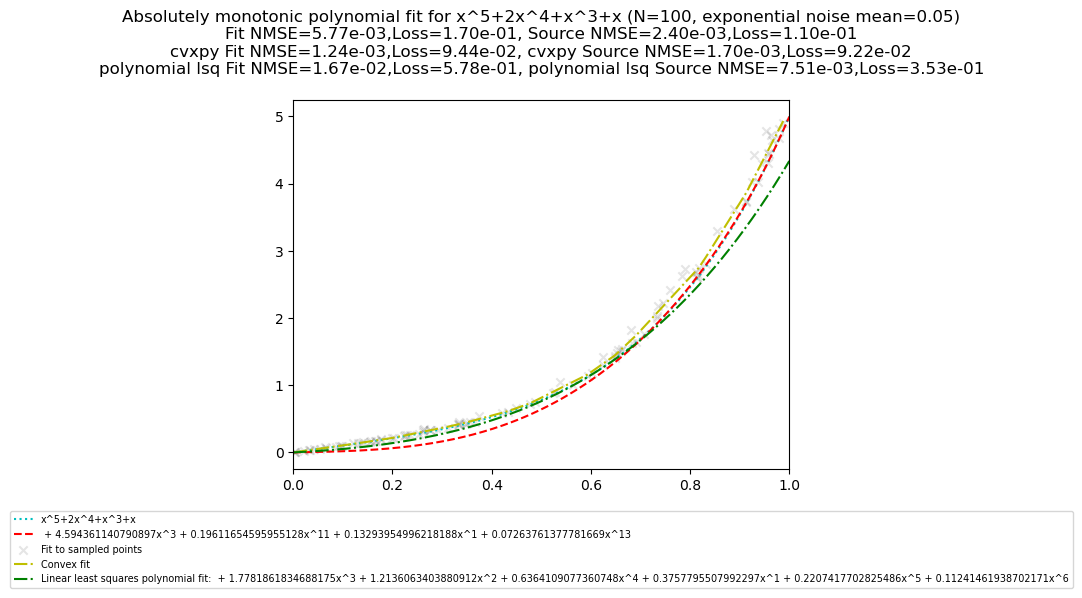

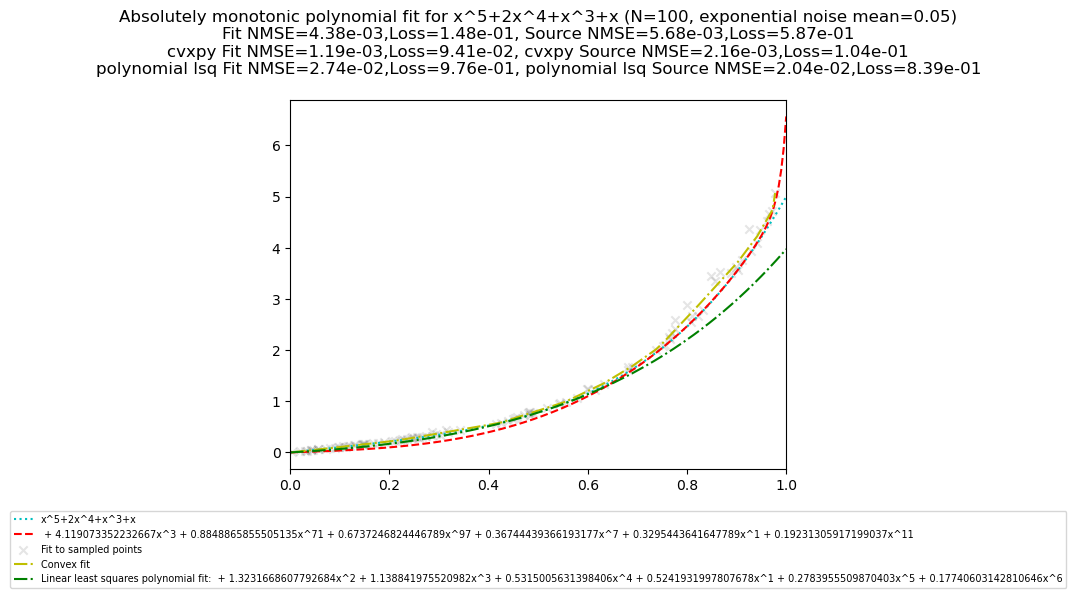

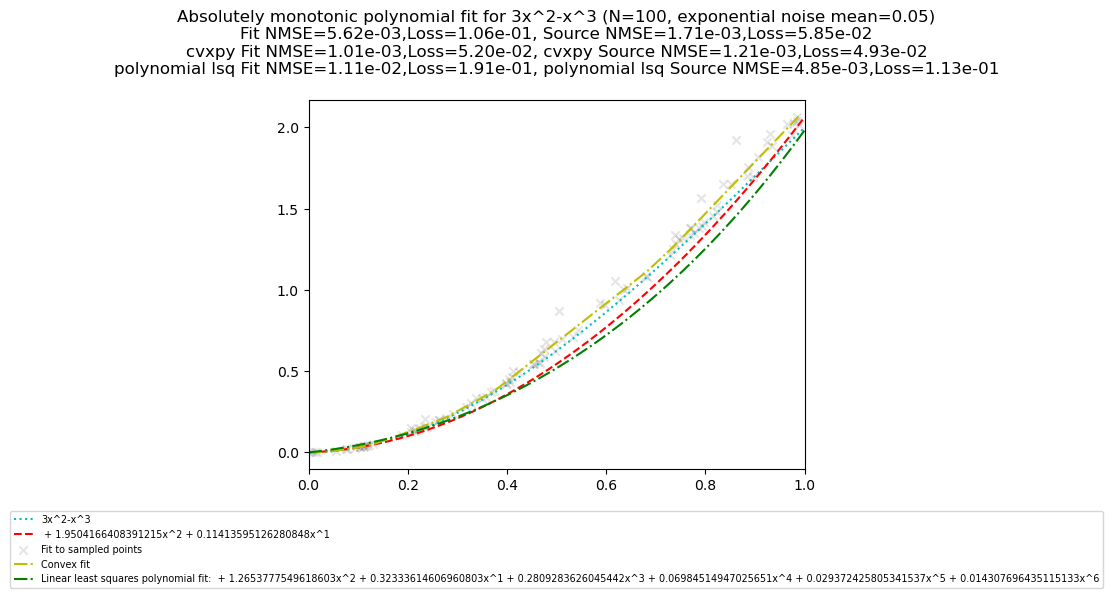

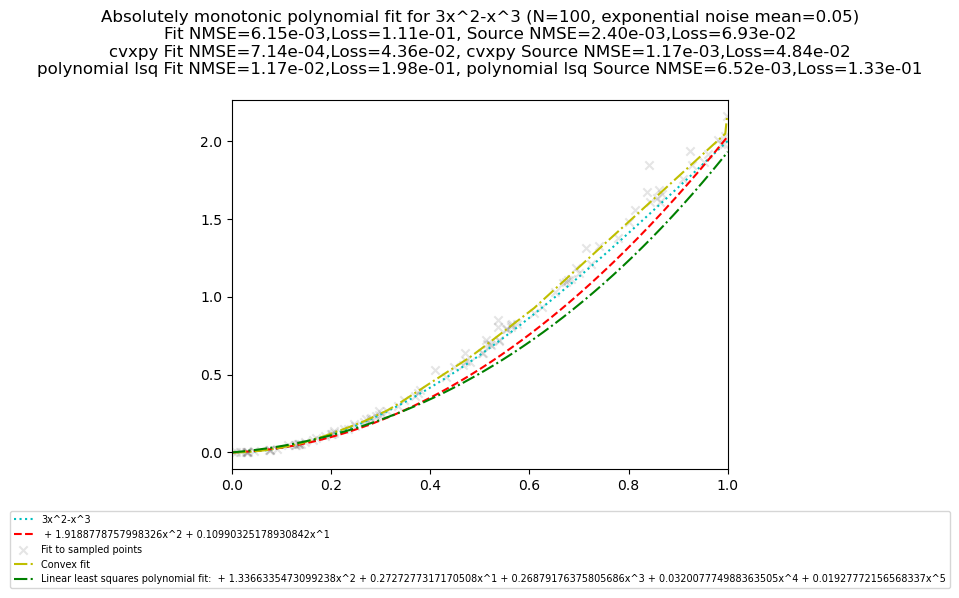

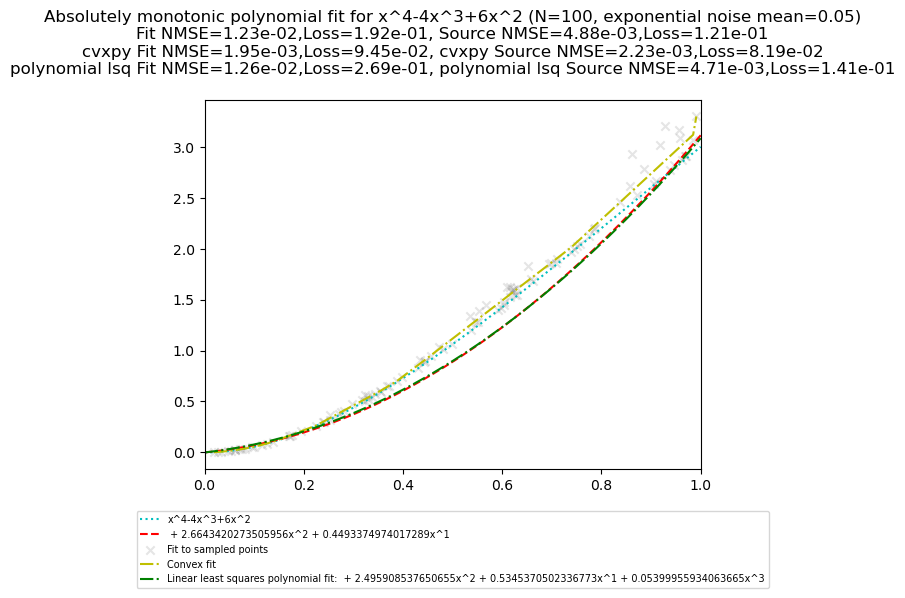

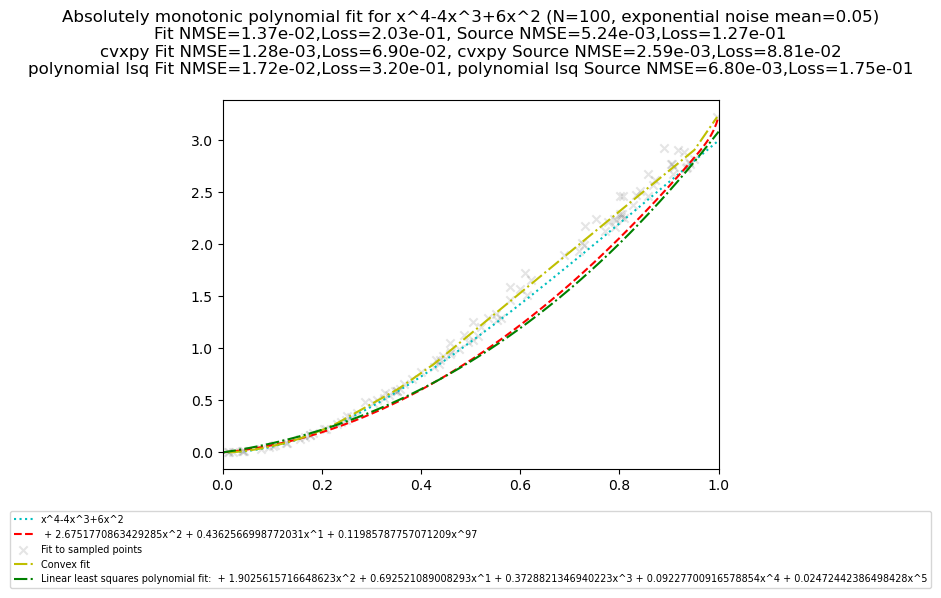

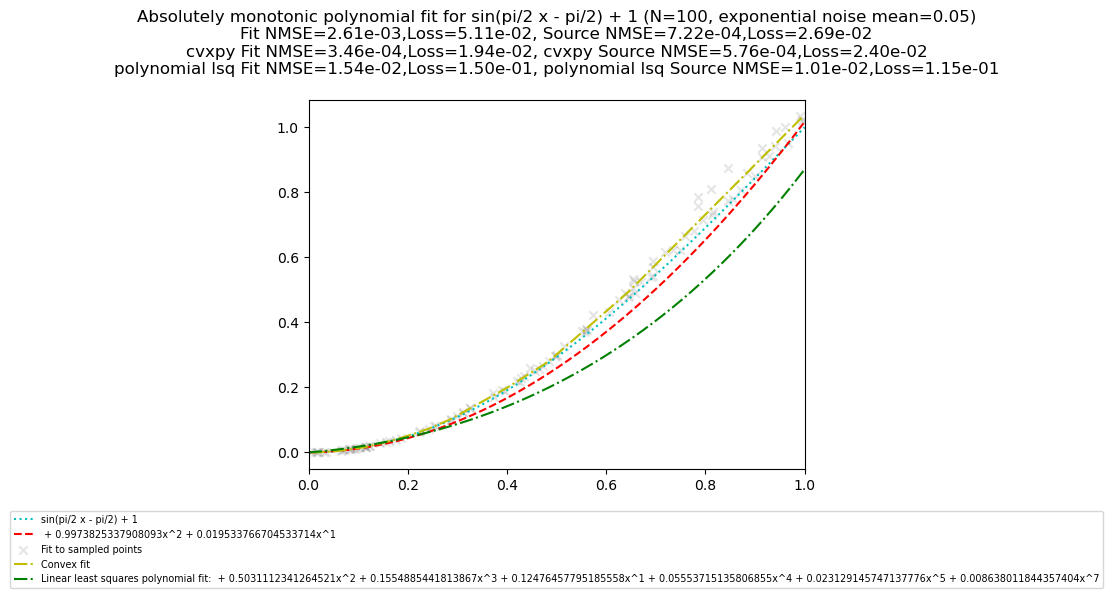

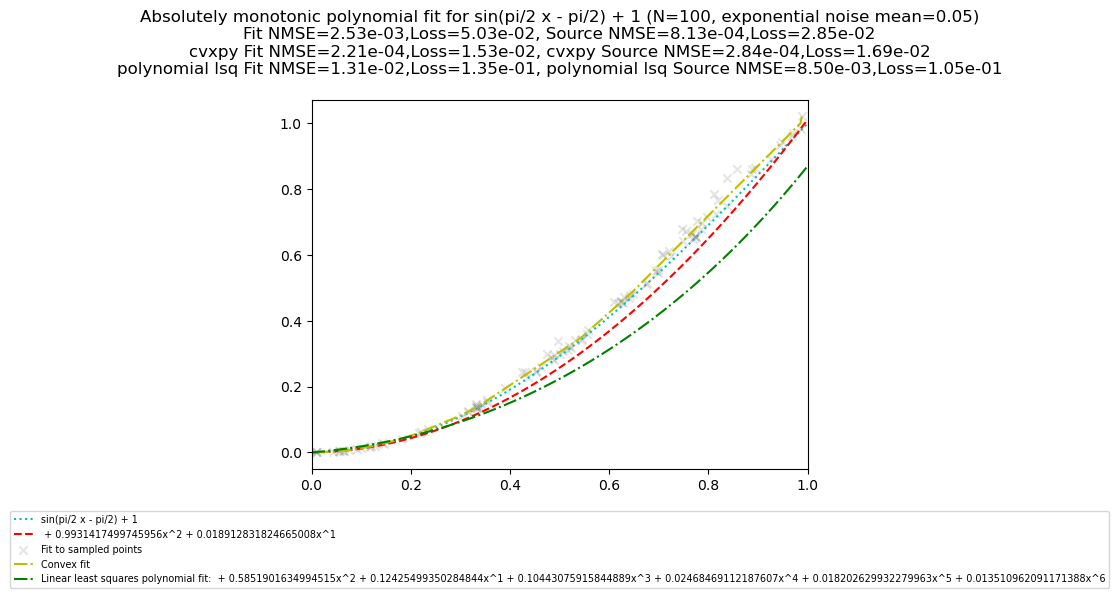

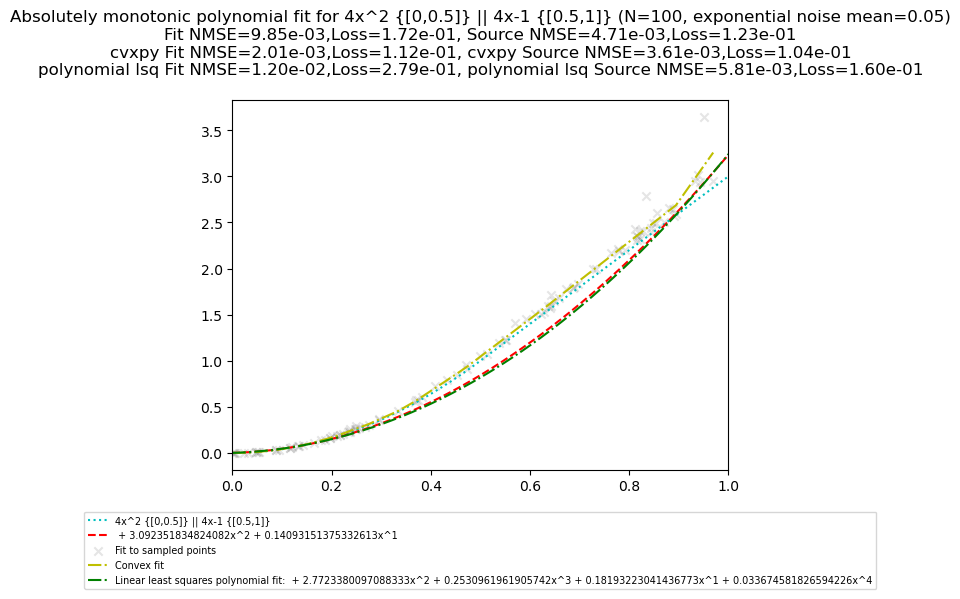

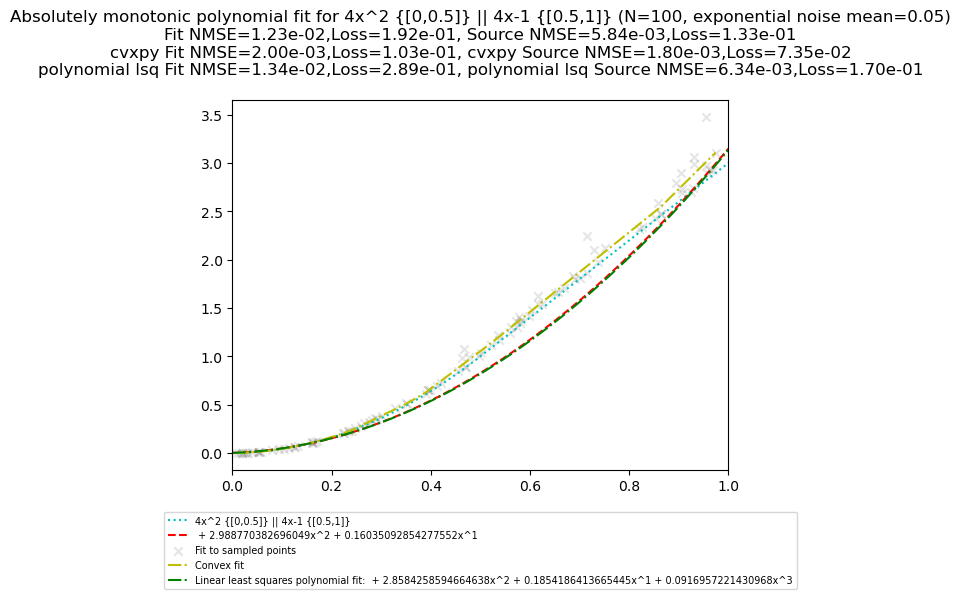

In [147]:
number_samples = 100
number_samples_test=50
number_tests = 5
exponential_noise_mean_mult=0.05
mean_power = 2
penalty_exponent = 1

for (fit_function, function_desc) in functions:
    many_results = monomial_sum_fit_many(fit_function, number_samples, number_tests, exponential_noise_mean_mult=exponential_noise_mean_mult, mean_power=mean_power, penalty_exponent=penalty_exponent)
    
    avg_result = many_results["avg_result"]
    worst_result = many_results["worst_result"]
    
    plot_full_result_monomial_sum_fit(fit_function, function_desc, number_samples, number_samples_test, exponential_noise_mean_mult, avg_result, mean_power=mean_power, penalty_exponent=penalty_exponent)
    plot_full_result_monomial_sum_fit(fit_function, function_desc, number_samples, number_samples_test, exponential_noise_mean_mult, worst_result, mean_power=mean_power, penalty_exponent=penalty_exponent)